<a href="https://colab.research.google.com/github/Quentini22/PRA3024/blob/main/GravitationalWavesAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exercise 1**

In [95]:
#This code was completed with LoadDataFiles.ipynb
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

from google.colab import drive
drive.mount('/content/drive')

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [96]:
import os

filename = 'GW_noisedata-2.npy'
extension = os.path.splitext(filename)[1]

print(extension)


.npy


**PART 1**

In [227]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import highpass
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd
from pycbc.psd import interpolate, aLIGOZeroDetHighPower

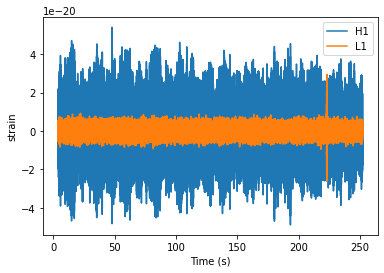

'pycbc.waveform.WaveformGenerator.supported_params'

In [276]:
#Loading the strain data
d = np.load('/content/drive/MyDrive/Colab Notebooks/GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
#comverting the data into GW timeSeries
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) 
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) 
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()

pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()
'pycbc.waveform.WaveformGenerator.supported_params'


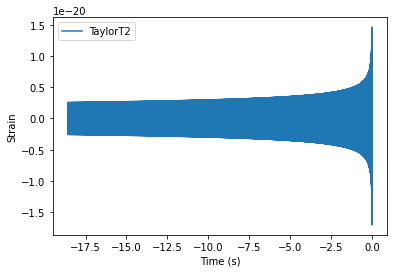

In [99]:
#Wave form template to match data using TaylorT2
for apx in ['TaylorT2']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=1,
                                 mass2=3,
                                 delta_t=1.0/2048,
                                 f_lower=40)

    pylab.plot(hp.sample_times, hp, label=apx)

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')

pylab.legend()
pylab.show()


**PART 2**

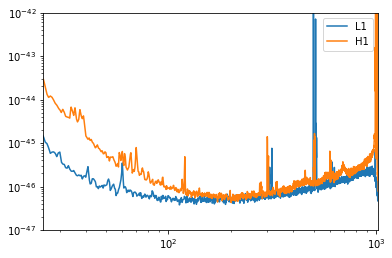

In [100]:
#Signal to noise ration needs to be plotted vs total mass.
#To do this, the power spectral density (psd) needs to be determined.
#power spectral density
#This was given in ExampleGravitationalWaveEventAnalysis.ipynb
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(25, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

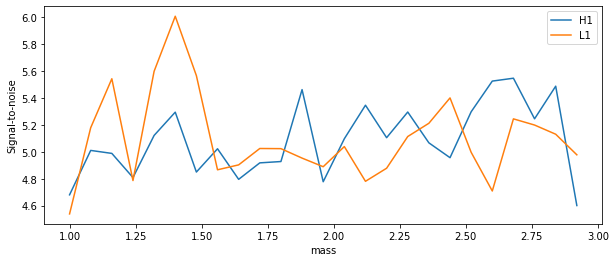

In [101]:
#This was given in ExampleGravitationalWaveEventAnalysis.ipynb
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

#mass range bewteen 1 to 3 Solar mass and where m1 = m2
#(ideally take an increment of 0.01 but it took too long for my computer)
mass1 = numpy.arange(1, 3, 0.08)   
mass2 = mass1                     


# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

# detector H1
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    # Generate a waveform with a given component mass; assumed equal mass and nonspinning 
    # change the approximation to a taylor approximation
    m = mass1[i]  # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                             mass1=m,
                             mass2=m,
                             delta_t=strain[ifo].delta_t,
                             f_lower=20.0)

    # Here we need to resize the vector in order for them to match our data and we crop
    # the outer ends of the graph by 4 to focus on the central data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)


    snr_H1 = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

# detector L1
ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    # Generate a waveform with a given component mass; assumed equal mass and nonspinning 
    # change the approximation to a taylor approximation as previously done
    m = mass1[i]  # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                             mass1=m,
                             mass2=m,
                             delta_t=strain[ifo].delta_t,
                             f_lower=20.0)

    # Here we need to resize the vector in order for them to match our data and we crop
    # the outer ends of the graph by 4 to focus on the central data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)

    snr = matched_filter(template, strain[ifo],
                          psd=psds[ifo], low_frequency_cutoff=20.0)

    snr_H1 = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list
#SNR versus total mass of the system plot 
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label='H1')
pylab.plot(mass1, snrs['L1'], label='L1')
pylab.legend(loc='best')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()


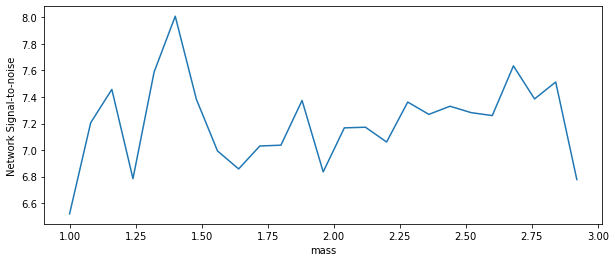

The best found Mass1=Mass2 is 1.40 solar masses (detector frame)


In [107]:
#combination of the data also taken from ExampleGravitationalWavesEventAnalysis.ipynp
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()
print("The best found Mass1=Mass2 is %2.2f solar masses (detector frame)" % mass1[ii])

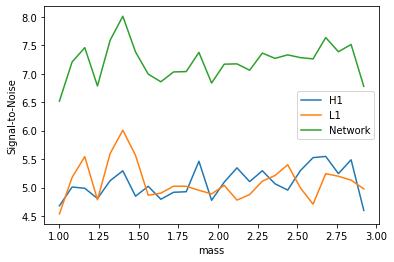

We found the best Mass1=Mass2 was 1.40 solar masses (detector frame)


In [108]:
#Network noise-to-signal ratio and plot it
nsnr = (numpy.array(snrs['H1'])**2 + numpy.array(snrs['L1'])**2)**0.5
ii = np.where(nsnr == max(nsnr))
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.plot(mass1, nsnr, label='Network')
pylab.legend()

pylab.ylabel('Signal-to-Noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

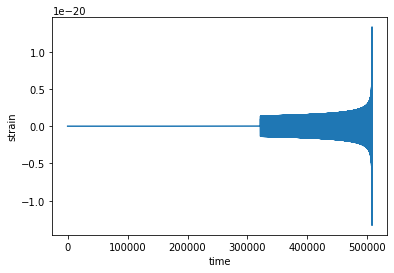

In [111]:
#Waveform according to the previously found best mass
#according to ExampleGravitationalWavesEventAnalysis.ipynp
from pycbc.waveform import get_td_waveform
import pylab
m = 1.38 # Solar masses (official value obtained with 0.01 increments)
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=25.0)

# We will resize the vector to match our data
# vector is rotated by this function by a predetermined period of time.
# we can use the start time to shift the merger into position
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

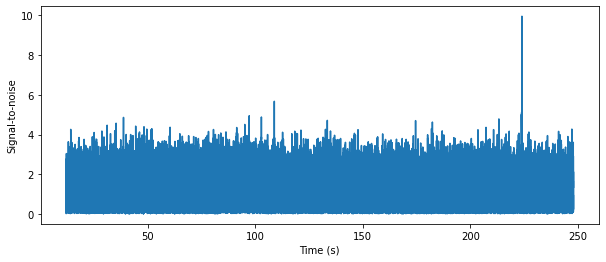

We found a signal at 224.02s with SNR 9.96


In [113]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.filter import matched_filter

# Set up variables
ifo = 'L1'
conditioned_strain = strain[ifo]
template_psd = psds[ifo]
low_frequency_cutoff = 20
time_window = 4  # seconds

# Calculate signal-to-noise ratio
snr = matched_filter(template, conditioned_strain,
                     psd=template_psd, low_frequency_cutoff=low_frequency_cutoff)
snr = snr.crop(time_window + 4, time_window)

# Plot signal-to-noise ratio
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

# Find peak signal-to-noise ratio and corresponding time
peak_idx = np.argmax(abs(snr))
peak_snr = snr[peak_idx]
peak_time = snr.sample_times[peak_idx]

# Print results
print(f"We found a signal at {peak_time:.2f}s with SNR {abs(peak_snr):.2f}")


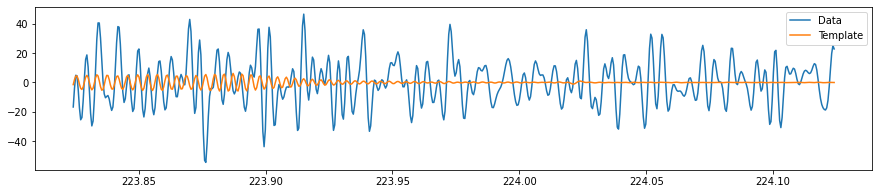

In [114]:
from pycbc.filter import sigma
# code achieved thanks to ExampleGravitationalWavesEventAnalysis.ipynp and LLBockenhoff
# Use of Q transform to handle data
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

#scaling the template 
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

#whitening template and data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

#Selecting the time around the merger
white_data = white_data.time_slice(time-0.2, time+0.1)
white_template = white_template.time_slice(time-.2, time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()


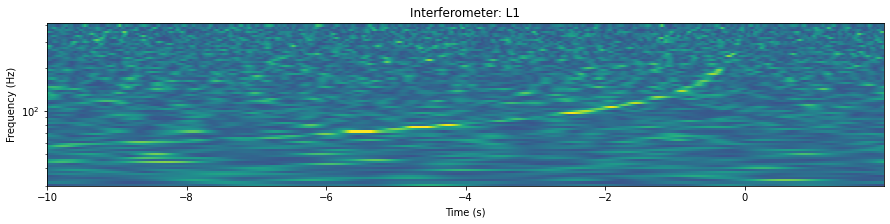

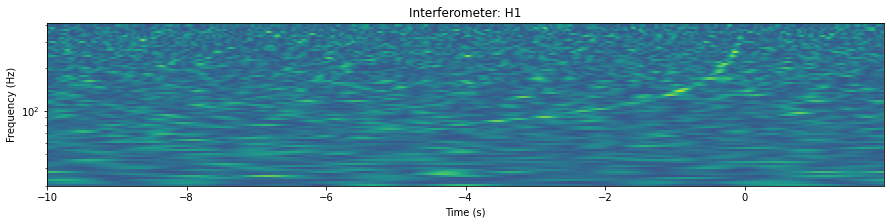

In [128]:
for ifo in ['L1', 'H1']:
    # Whitening the data
    org_data = (stilde[ifo] / psds[ifo] ** 0.5).to_timeseries()
    zoom = org_data.time_slice(time - 10, time + 2)

    #Calculating the Q transform 
    times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times - time, freqs, power**0.6, vmin=-2, vmax=6)
    pylab.ylim(30, 412)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')
     

**Part 3**

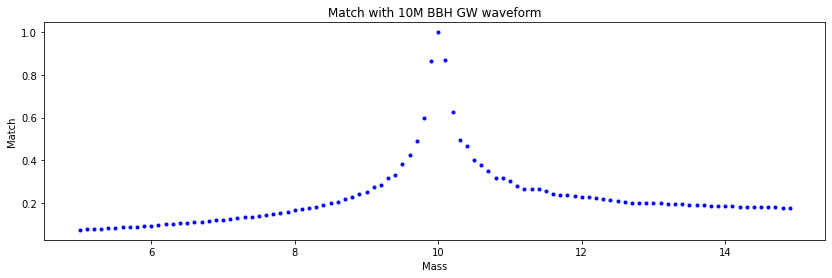

In [124]:
# code inspired by LLBockenhoff 
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 30
sample_rate = 4096
masses = np.arange(5,15,0.1)
matches = {}

for mass in masses:
  # Generating the two waveforms to compare
  hp, hc = get_td_waveform(approximant="TaylorT2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT2",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  #Resize the waveforms and generate the aLIGO PSD
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m
#print plot 
pylab.figure(figsize=[14, 4])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'b.')
pylab.show()

**Exercise 2 Part 1**

In [232]:
#Loading the strain data
d = np.load('/content/drive/MyDrive/Colab Notebooks/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
strain = d[:, 1] 
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]-dt[0]) 
data = data 




In [233]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc.filter import highpass
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd
from pycbc.psd import welch, interpolate
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pycbc.waveform
from pycbc.types import TimeSeries


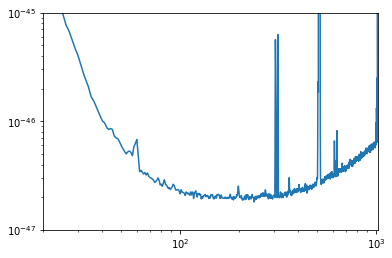

In [235]:
#power spectral density inspired by the first exercise
#same approach is used also inspired from ExampleGravitationalWaveEventAnalysis.ipynb
psds = interpolate(welch(d), 1.0 / d.duration)

pylab.loglog(psds.sample_frequencies, psds, psds)
pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-45)
pylab.show()

In [250]:
#similar approach as in the first exercise but this time with a range of 5 to 10 
#solar masses and along with a conversion of data in a a frequency series.
#use of TaylorF2 approximation
flow = 20 
stilde = data.to_frequencyseries()
masses = np.arange(5,10,0.5) 

#loop through masses
for mass in masses:
  hp, hc = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                                          mass1 = mass,
                                          mass2 = mass,
                                          f_lower = flow, 
                                          delta_f=stilde.delta_f)
  #resize according to data
  hp.resize(len(stilde))
  template = hp.cyclic_time_shift(hp.start_time)


  snr = pycbc.filter.matched_filter(hp, stilde, 
                                  psd = psds,
                                  low_frequency_cutoff = flow)
  snr = snr[len(snr)//4:len(snr) * 3//4]

  #checking if a gravitational wave with a greater SNR than 8 has been detected.
  peak = abs(snr).numpy().argmax()
  snrp = snr[peak]
  print(snrp)
  if(snrp > 8):
    print('The equal masses of {} give an SNR greater that 8 in {}'.format(mass, abs(snrp)) )
  else:
    print('No SNR greater that 8 was detected. The max mass was {}'.format(abs(snrp)))



(-5.0854467284054765+0.3632290540648819j)
No SNR greater that 8 was detected. The max mass was 5.0984020803744805
(1.2833695084319874-5.0618234659820125j)
No SNR greater that 8 was detected. The max mass was 5.221981816890893
(2.557523796860903+4.388823030894467j)
No SNR greater that 8 was detected. The max mass was 5.079635377467511
(-4.431884915787411-3.8377510436284092j)
No SNR greater that 8 was detected. The max mass was 5.862587908053485
(5.06566537828327-0.5904621048257447j)
No SNR greater that 8 was detected. The max mass was 5.0999618843647285
(-4.943568699606104+0.991702676447582j)
No SNR greater that 8 was detected. The max mass was 5.04205768374366
(-5.652859838792335+1.3800487440060853j)
No SNR greater that 8 was detected. The max mass was 5.818879522112833
(-5.437084933845937-0.82749808275233j)
No SNR greater that 8 was detected. The max mass was 5.499695051074492
(-5.155796269715823-1.5840987373953805j)
No SNR greater that 8 was detected. The max mass was 5.3936633176935

**Part 2**

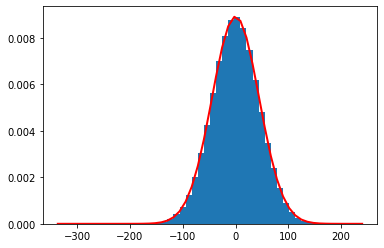

In [263]:
#plotting steps inspired by ka-grb and and LLBockenhoff
#whitening the data
# Convert data to frequency series and whiten it using the given `psds`
white_data = (data.to_frequencyseries() / psds ** 0.5).to_timeseries()
white_data = white_data.crop(4, 4)

mu, sigma = np.mean(white_data), np.std(white_data)
s = np.random.normal(mu, sigma, white_data.shape[0])

# Plot a histogram of the whitened data
hist, bins, _ = plt.hist(white_data, bins=50, density=True, label='data')

# Plot the normal distribution on the same graph for comparison
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(bins - mu)**2 / (2 * sigma**2)),
         linewidth=2, color='r')

plt.show()


**Part 3**

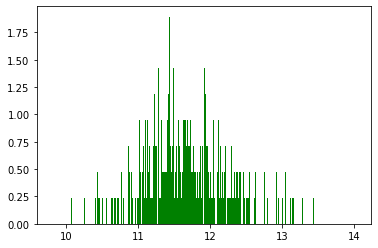

In [274]:
#code with similar approach to above but with the implementation of chunks of equally 
#divided time intervals. 
from scipy.stats import norm
from pycbc.filter import sigmasq

from pycbc.waveform import get_fd_waveform 
hp, hc = get_fd_waveform(approximant="TaylorF2", 
                         mass1=3, 
                         mass2=3, 
                         delta_f=1.0/(200.0) , 
                         distance = 500,  #Luminosity distance = 500 Mpc 
                         f_lower=20.0, f_final = 2048.0)    

#splitting data by chunks of 500 
data_slice = len(data) // 500
SNRlist = []
fract = round(len(data)/500)

for i in range(0, 500): 
   chunk = data[i * data_slice: (i+1)*data_slice]
   psds = pycbc.psd.interpolate(pycbc.psd.welch(chunk), hp.delta_f)
   SNR = (pycbc.filter.sigmasq(hp, psds))**0.5
   SNRlist.append(SNR)

#Plotting histogram
plt.hist(SNRlist, bins = 500, color = "green", density=True)
plt.show()

this seems like it could be a gausian distribution however, there doesn't seem to be one clear central peak, rather two peaks slightly towards each side of the center.